In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
import itertools
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

import warnings
warnings.simplefilter('ignore')

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df = pd.read_csv('BikeShare.csv').set_index('Instant')

In [3]:
print(df.shape)
df.head()

(17379, 11)


,Riders,Season,Month,Hour,Holiday,Weekday,Workday,Weather,Temperature,Humidity,Wind
Instant,,,,,,,,,,,
1,16,1,1,0,0,6,0,1,37,0.81,0.0
2,40,1,1,1,0,6,0,1,36,0.80,0.0
3,32,1,1,2,0,6,0,1,36,0.80,0.0
4,13,1,1,3,0,6,0,1,37,0.75,0.0
5,1,1,1,4,0,6,0,1,37,0.75,0.0


In [4]:
df.tail()

,Riders,Season,Month,Hour,Holiday,Weekday,Workday,Weather,Temperature,Humidity,Wind
Instant,,,,,,,,,,,
17375,119,1,12,19,0,1,1,2,34,0.60,0.1642
17376,89,1,12,20,0,1,1,2,34,0.60,0.1642
17377,90,1,12,21,0,1,1,1,34,0.60,0.1642
17378,61,1,12,22,0,1,1,1,36,0.56,0.1343
17379,49,1,12,23,0,1,1,1,36,0.65,0.1343


In [5]:
len(df)/24

724.125

# Determine the time period
At first glance, each row represents a hourly record. The whole dataset seems to be continuous for about 724 days (2 years and most likely a peried of two calendar years). The exact dates are not provided, but could be inferred from Month and Weekday. Take a look at January and we can find there are only 29 days in the first year. By examining Weekday, the two missing days could be pinned: a Tuesday between `16` and `17`, and a Thursday between `24` and `25`. Then we can confirm the first line the dataset begins at Jan 1 of that year and it's a Saturday. Searching from the calendar, we found the most recent eligible year is 2011. Because 2012 is a leap year, we can easily check the number of days in Feb to confirm our assumption. Now we are pretty sure the dataset is a record of 2011 and 2012.

In [6]:
df[(df.Month == 1) & (df.Hour == 0)].reset_index()

,Instant,Riders,Season,Month,Hour,Holiday,Weekday,Workday,Weather,Temperature,Humidity,Wind
0,1,16,1,1,0,0,6,0,1,37,0.81,0.0000
1,25,17,1,1,0,0,0,0,2,57,0.88,0.2985
2,48,5,1,1,0,0,1,1,1,27,0.44,0.3582
3,70,5,1,1,0,0,2,1,1,25,0.55,0.1045
4,93,6,1,1,0,0,3,1,1,34,0.64,0.0000
5,116,11,1,1,0,0,4,1,1,32,0.55,0.0000
6,139,17,1,1,0,0,5,1,2,27,0.64,0.1940
7,162,25,1,1,0,0,6,0,2,27,0.51,0.1642
8,186,25,1,1,0,0,0,0,1,12,0.42,0.3881
9,210,5,1,1,0,0,1,1,1,18,0.50,0.2836


In [7]:
df[(df.Month == 2) & (df.Hour == 0)].reset_index()

,Instant,Riders,Season,Month,Hour,Holiday,Weekday,Workday,Weather,Temperature,Humidity,Wind
0,689,8,1,2,0,0,2,1,2,25,0.64,0.1045
1,712,2,1,2,0,0,3,1,3,32,0.93,0.1045
2,736,12,1,2,0,0,4,1,1,23,0.40,0.4478
3,759,13,1,2,0,0,5,1,2,34,0.44,0.0000
4,782,39,1,2,0,0,6,0,2,32,0.70,0.1642
5,806,39,1,2,0,0,0,0,1,34,0.70,0.1940
6,830,15,1,2,0,0,1,1,1,37,0.65,0.0000
7,854,10,1,2,0,0,2,1,2,41,0.87,0.0000
8,878,17,1,2,0,0,3,1,1,12,0.36,0.3582
9,901,16,1,2,0,0,4,1,3,19,0.86,0.1940


Now we can create a new feature `Year` for our dataset.

In [8]:
df.loc[8644:8647]

,Riders,Season,Month,Hour,Holiday,Weekday,Workday,Weather,Temperature,Humidity,Wind
Instant,,,,,,,,,,,
8644,38,1,12,22,0,6,0,1,50,0.62,0.1343
8645,31,1,12,23,0,6,0,1,48,0.66,0.0000
8646,48,1,1,0,0,0,0,1,48,0.66,0.0000
8647,93,1,1,1,0,0,0,1,45,0.66,0.1343


In [9]:
(df.index > 8645)

array([False, False, False, ...,  True,  True,  True])

In [10]:
df['Year'] = (df.index > 8645) + 2011

# Impute date
Next, we can further impute the date for each row. This is not simple and direct, especially there are several missing days. 

In [11]:
start = datetime(2011, 1, 1)
end = datetime(2012, 12, 31)
date_range = pd.date_range(start, end)
date = pd.DataFrame(date_range, columns=['date'])
date['Weekday'] = (date.date.dt.weekday + 1).replace(7, 0)
date['Year'] = date.date.dt.year
date['Month'] = date.date.dt.month
date['Day'] = date.date.dt.day
date.head()

,date,Weekday,Year,Month,Day
0,2011-01-01,6,2011,1,1
1,2011-01-02,0,2011,1,2
2,2011-01-03,1,2011,1,3
3,2011-01-04,2,2011,1,4
4,2011-01-05,3,2011,1,5


In [12]:
df_date = []
on_cols = ['Year', 'Month', 'Weekday']

j = 0
last = tuple(df[on_cols].loc[1])
for i in df.index:
    current = tuple(df[on_cols].loc[i])
    if current != last:
        last = current
        while current != tuple(date[on_cols].loc[j]):
            j += 1
    df_date.append(date.date.loc[j])

df['date'] = df_date

To double check our imputation is correct, we compare original feature `Weekday` with the weekday of our new feature `date`. Note:
- in our dataset `Weekday`: 0 is Sunday and 6 is Saturday
- in `pandas.Series.dt.weekday`: 0 is Monday and 6 is Sunday

In [13]:
matched = ((df.date.dt.weekday + 1).replace(7, 0) == df.Weekday).sum()
print('{}/{} rows matched.'.format(matched, len(df)))

17379/17379 rows matched.


In [14]:
df['Day'] = df.date.dt.day

# Pairplot
Now it's time to use pairplot to take a look at the relationships between features.

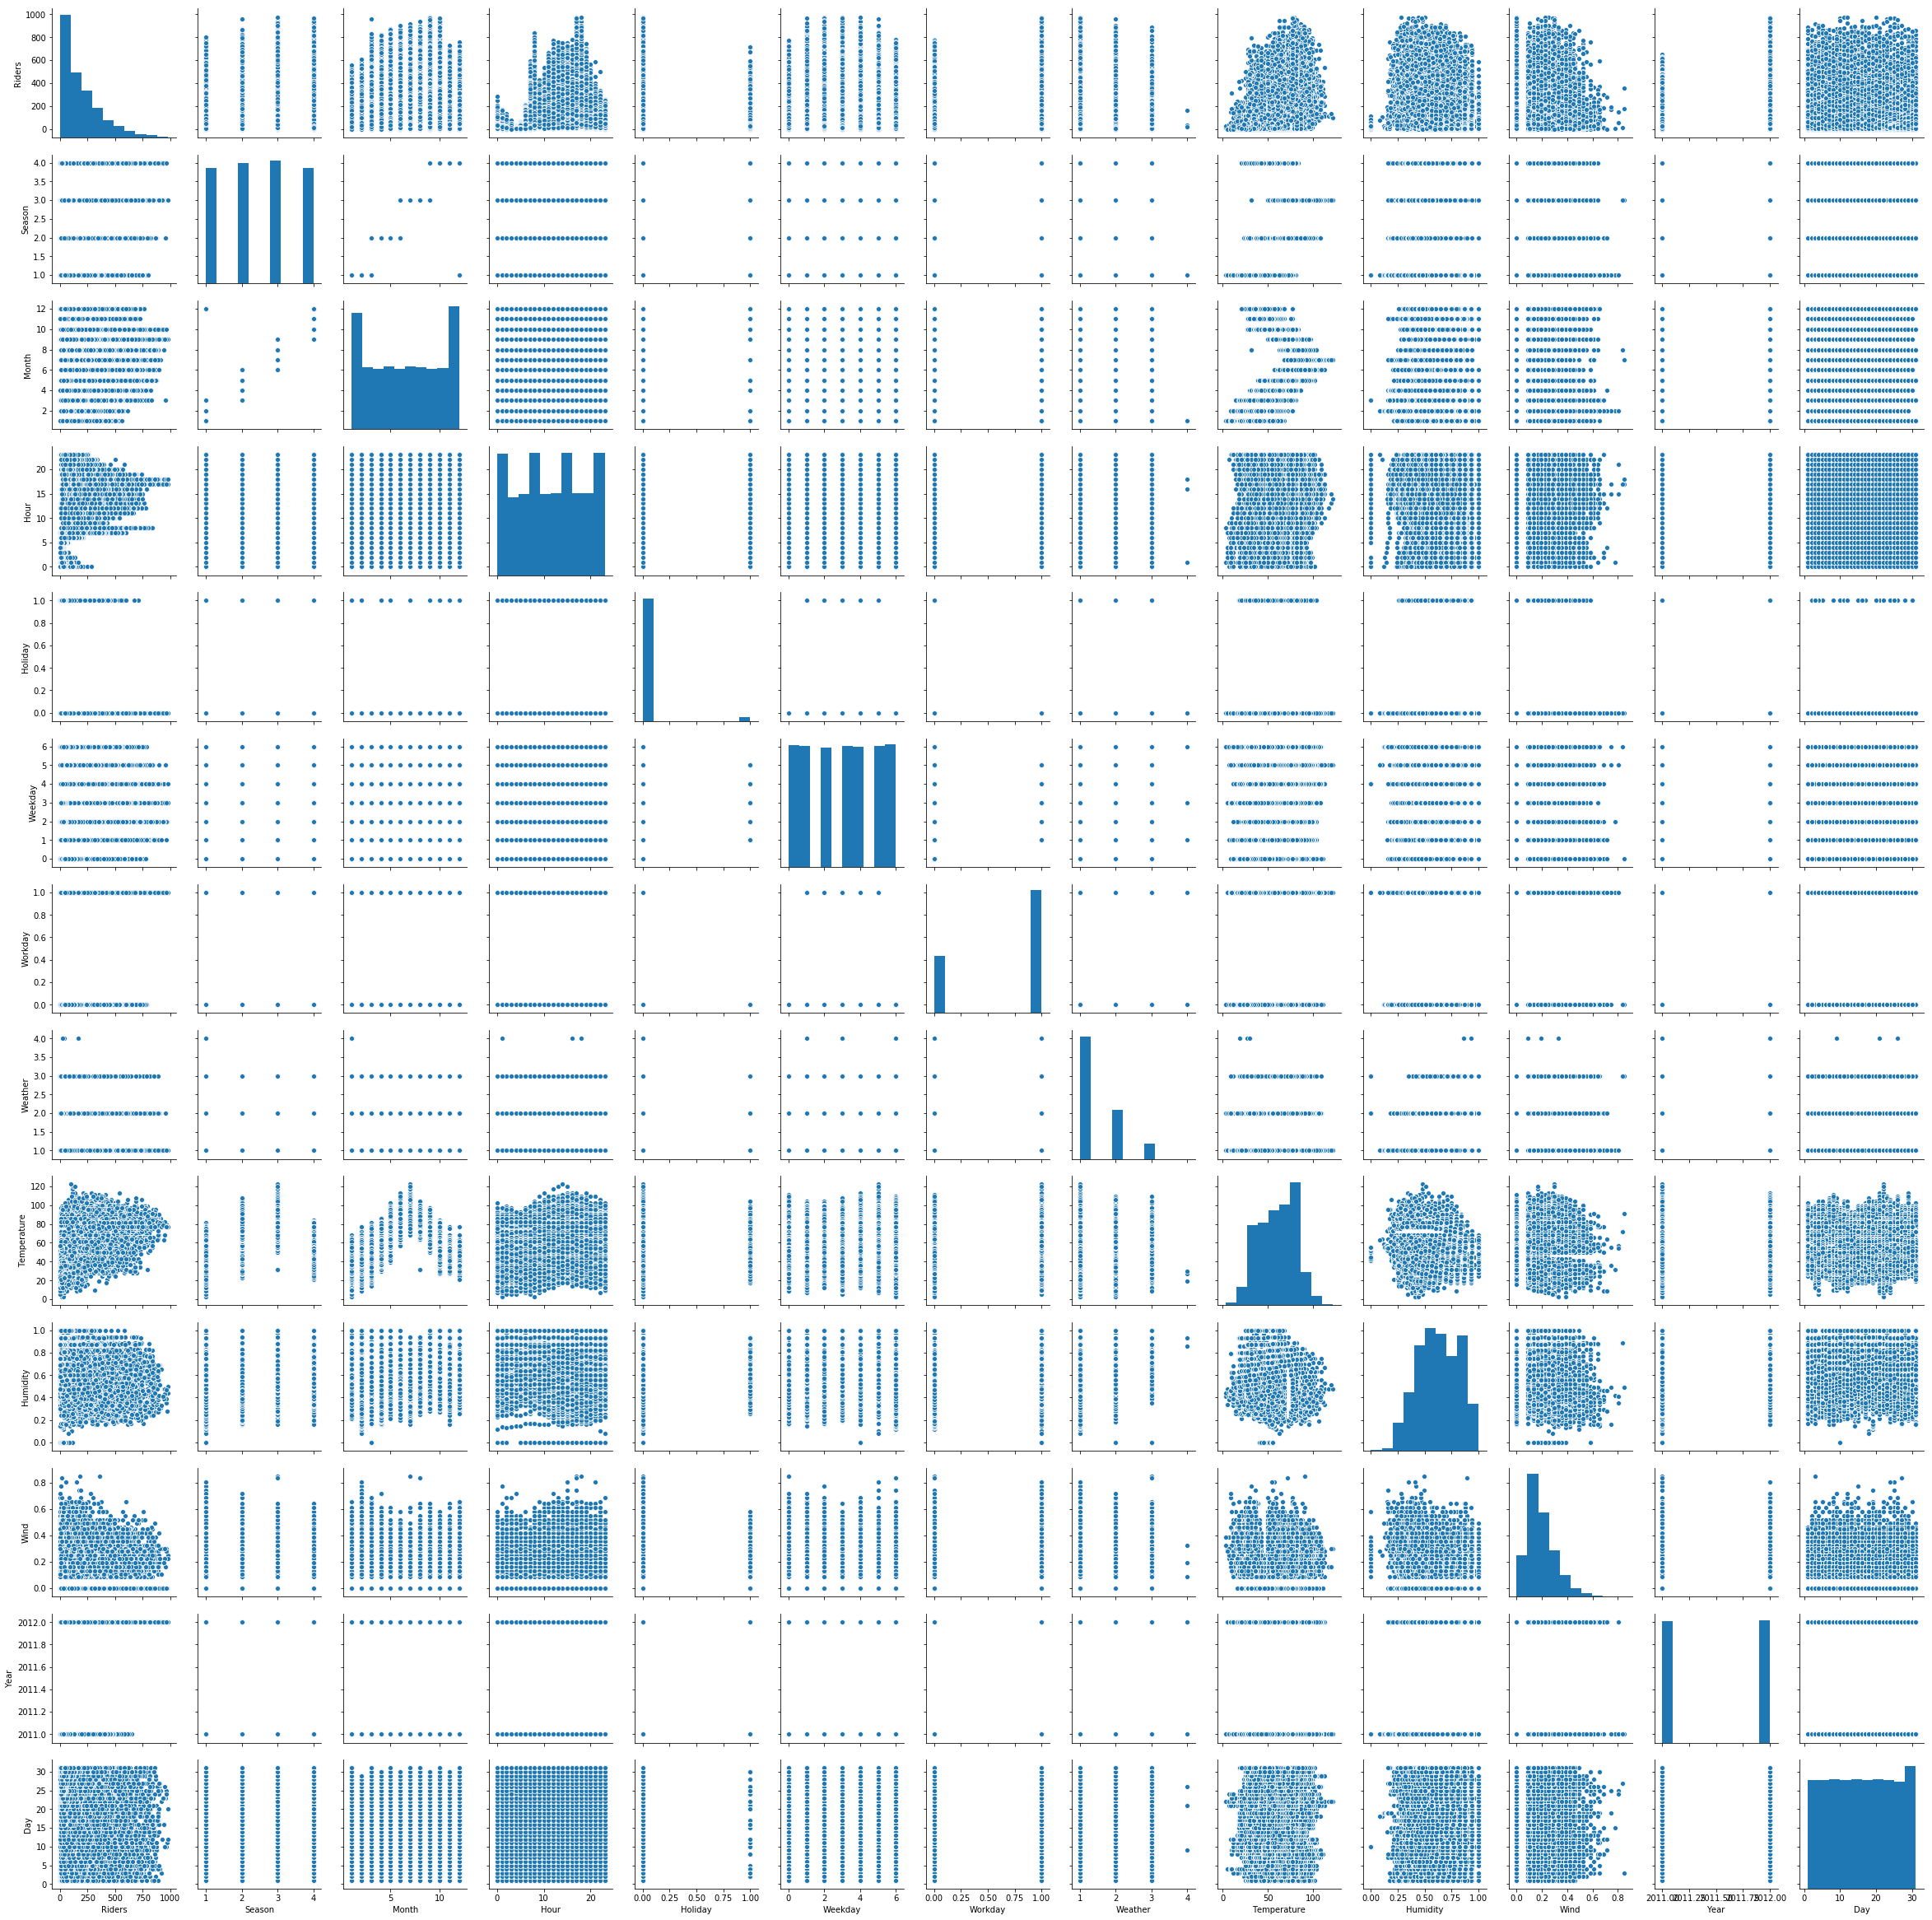

In [15]:
sns.pairplot(df);

# Findings
1. 2011-2012
2. Season
3. One day in Aug. 2012 (14132:14155) Temperature == 32 outlier
4. Weather 4 is useless
5. One day in Mar. 2011 (1552:1573) Humanity == 0 outlier

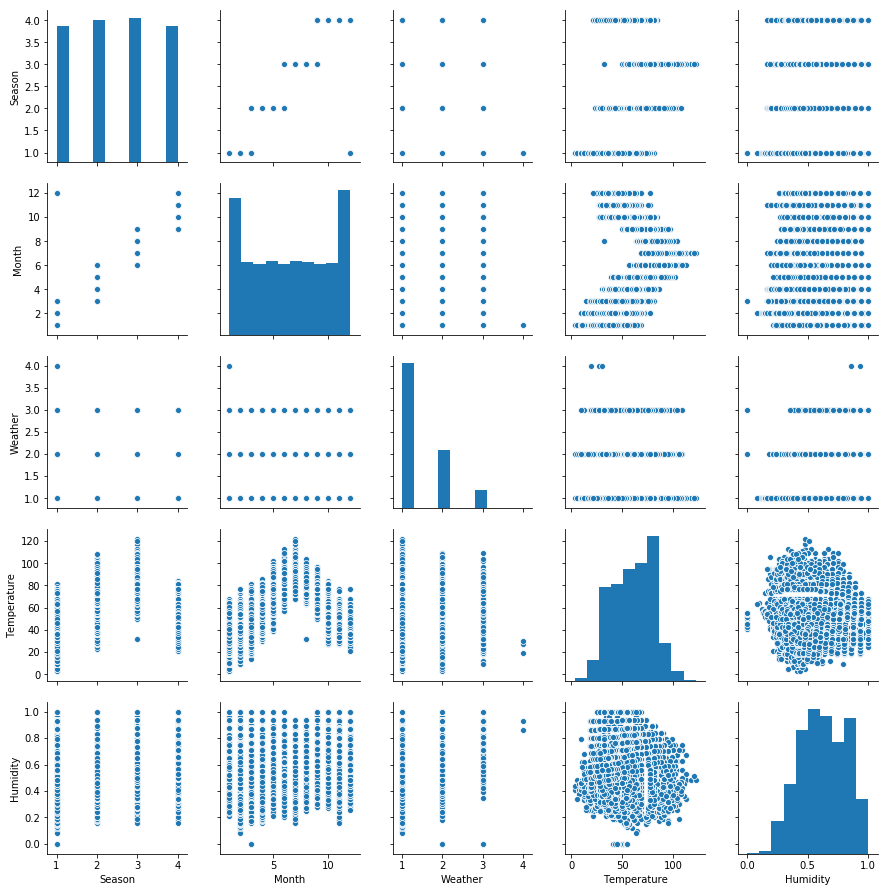

In [16]:
sns.pairplot(df[['Season', 'Month', 'Weather', 'Temperature', 'Humidity']]);

# TO DO:
1. Season cut point
2. Temperature outlier
3. Humidity outlier
4. Weather 4

## 1. Season
...

## 2. Temperature Outlier
...

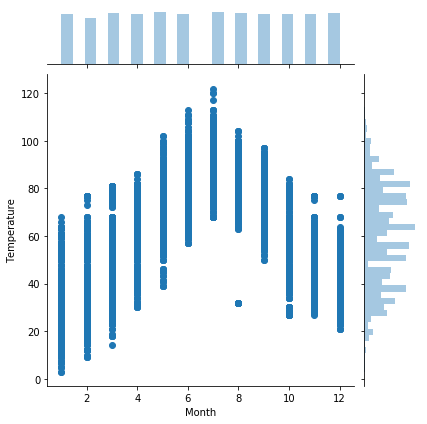

In [17]:
sns.jointplot(x="Month", y="Temperature", data=df);

In [18]:
df[(df.Month == 8) & (df.Temperature < 40)]

,Riders,Season,Month,Hour,Holiday,Weekday,Workday,Weather,Temperature,Humidity,Wind,Year,date,Day
Instant,,,,,,,,,,,,,,
14132,88,3,8,0,0,5,1,1,32,0.57,0.1642,2012,2012-08-17,17
14133,54,3,8,1,0,5,1,1,32,0.65,0.1045,2012,2012-08-17,17
14134,19,3,8,2,0,5,1,1,32,0.61,0.1343,2012,2012-08-17,17
14135,6,3,8,3,0,5,1,1,32,0.65,0.1045,2012,2012-08-17,17
14136,9,3,8,4,0,5,1,1,32,0.73,0.1642,2012,2012-08-17,17
14137,36,3,8,5,0,5,1,1,32,0.73,0.1045,2012,2012-08-17,17
14138,157,3,8,6,0,5,1,1,32,0.78,0.1343,2012,2012-08-17,17
14139,379,3,8,7,0,5,1,1,32,0.73,0.1045,2012,2012-08-17,17
14140,668,3,8,8,0,5,1,1,32,0.65,0.1343,2012,2012-08-17,17


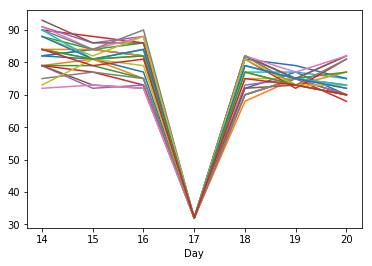

In [19]:
oneweek = df[(df.Year == 2012) & (df.Month == 8) & (14 <= df.Day) & (df.Day <= 20)]
for h in range(24):
    oneweek[oneweek.Hour == h].set_index(oneweek[oneweek.Hour == h].Day).Temperature.plot()

...

In [20]:
df.loc[(df.Year == 2012) & (df.Month == 8) & (df.Day == 17), ['Temperature']] = (
    df[(df.Year == 2012) & (df.Month == 8) & (df.Day == 16)].Temperature.values +
    df[(df.Year == 2012) & (df.Month == 8) & (df.Day == 18)].Temperature.values) / 2

## 3. Humidity Outlier
...

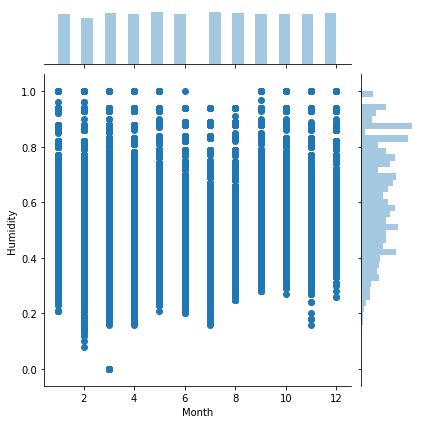

In [21]:
sns.jointplot(x="Month", y="Humidity", data=df);

In [22]:
df[df.Humidity == 0]

,Riders,Season,Month,Hour,Holiday,Weekday,Workday,Weather,Temperature,Humidity,Wind,Year,date,Day
Instant,,,,,,,,,,,,,,
1552,3,1,3,0,0,4,1,3,41.0,0.0,0.2537,2011,2011-03-10,10
1553,2,1,3,1,0,4,1,3,41.0,0.0,0.2537,2011,2011-03-10,10
1554,1,1,3,2,0,4,1,3,41.0,0.0,0.2537,2011,2011-03-10,10
1555,3,1,3,5,0,4,1,3,45.0,0.0,0.1940,2011,2011-03-10,10
1556,12,1,3,6,0,4,1,3,43.0,0.0,0.3284,2011,2011-03-10,10
1557,37,1,3,7,0,4,1,3,50.0,0.0,0.2239,2011,2011-03-10,10
1558,44,1,3,8,0,4,1,3,50.0,0.0,0.2836,2011,2011-03-10,10
1559,24,1,3,9,0,4,1,3,52.0,0.0,0.2239,2011,2011-03-10,10
1560,17,1,3,10,0,4,1,3,52.0,0.0,0.1642,2011,2011-03-10,10


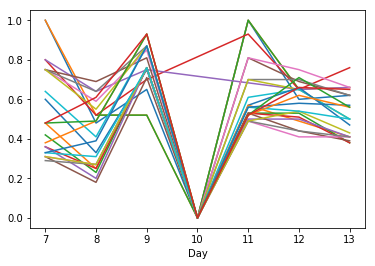

In [23]:
oneweek2 = df[(df.date >= '2011-03-07') & (df.date <= '2011-03-13')]
for h in range(24):
    oneweek2[oneweek2.Hour == h].set_index(oneweek2[oneweek2.Hour == h].Day).Humidity.plot()

...

In [24]:
df = df[df.Humidity > 0]

## 4. Weather
...

In [25]:
df[df.Weather == 4]

,Riders,Season,Month,Hour,Holiday,Weekday,Workday,Weather,Temperature,Humidity,Wind,Year,date,Day
Instant,,,,,,,,,,,,,,
586,36,1,1,16,0,3,1,4,27.0,0.93,0.3284,2011,2011-01-26,26
8855,164,1,1,18,0,1,1,4,30.0,0.86,0.0896,2012,2012-01-09,9
9124,23,1,1,1,0,6,0,4,19.0,0.86,0.1940,2012,2012-01-21,21


In [26]:
df.Weather = df.Weather.replace(4, 3)

# Relationships between Categorical Variables and Target Variable (Riders)

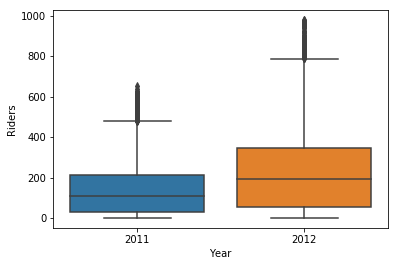

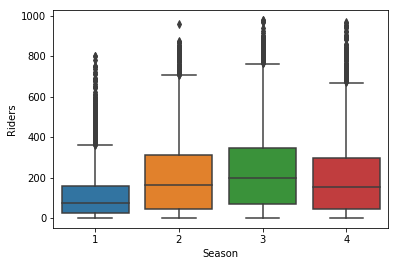

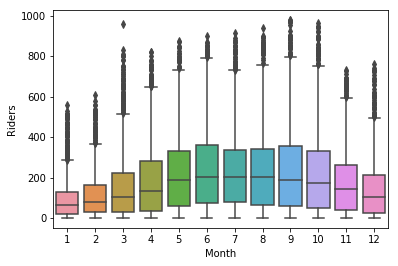

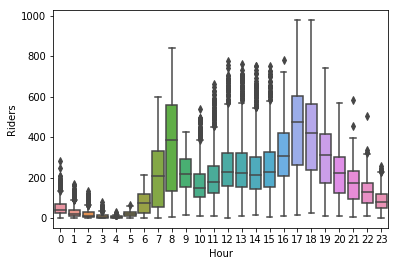

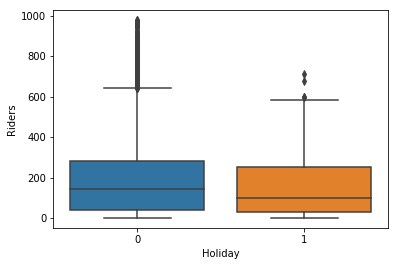

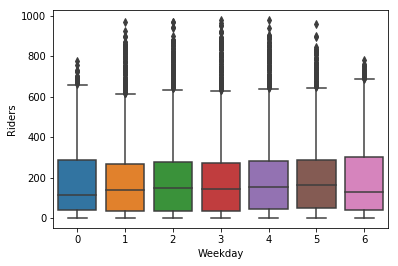

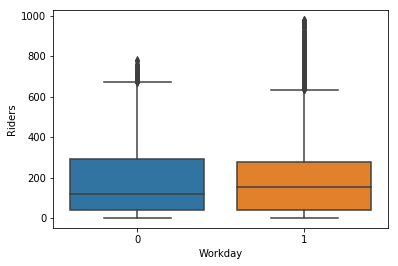

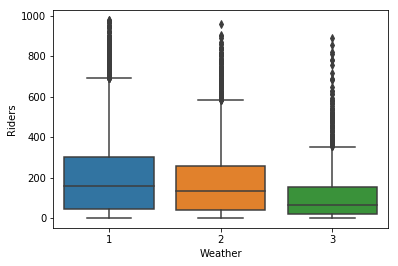

In [27]:
categ_cols = ['Year', 'Season', 'Month', 'Hour', 'Holiday', 'Weekday', 'Workday', 'Weather']
for col in categ_cols:
    sns.boxplot(x=col, y='Riders', data=df)
    plt.show()

# Correlation Coefficients

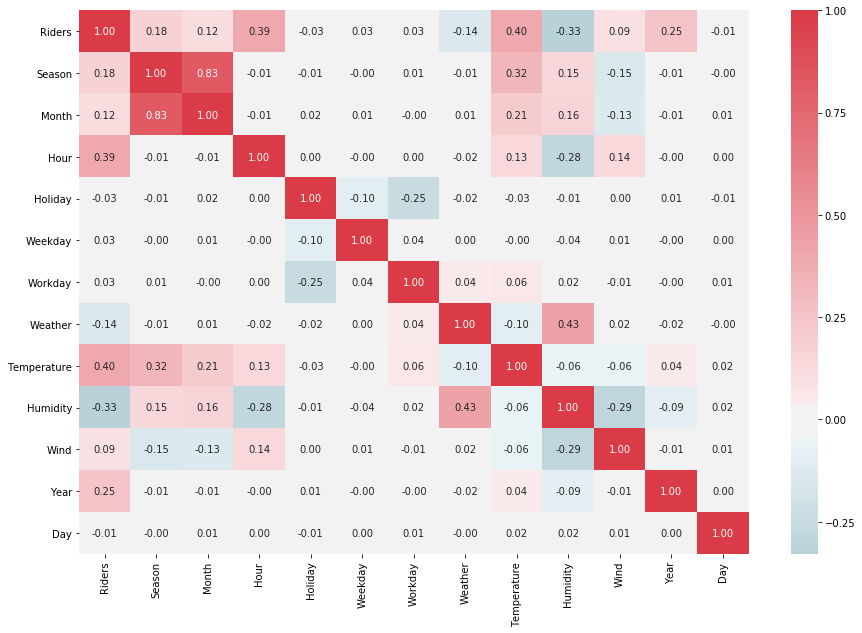

In [28]:
plt.figure(figsize=(15, 10))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df.drop('date', axis=1).corr(), cmap=colormap, center=0, annot=True, fmt=".2f")
plt.show()

# Transform Periodic Features
...

In [29]:
def hour2circle(hour):
    angle = 2*np.pi / 24
    return np.sin(angle * hour), np.cos(angle * hour)

def dayofyear2circle(dayofyear):
    angle = 2*np.pi / 365
    return np.sin(angle * dayofyear), np.cos(angle * dayofyear)

In [30]:
df['Hour_x1'] = df.Hour.apply(lambda x: hour2circle(x)[0])
df['Hour_x2'] = df.Hour.apply(lambda x: hour2circle(x)[1])
df['DayofYear_x1'] = df.date.dt.dayofyear.apply(lambda x: dayofyear2circle(x)[0])
df['DayofYear_x2'] = df.date.dt.dayofyear.apply(lambda x: dayofyear2circle(x)[1])

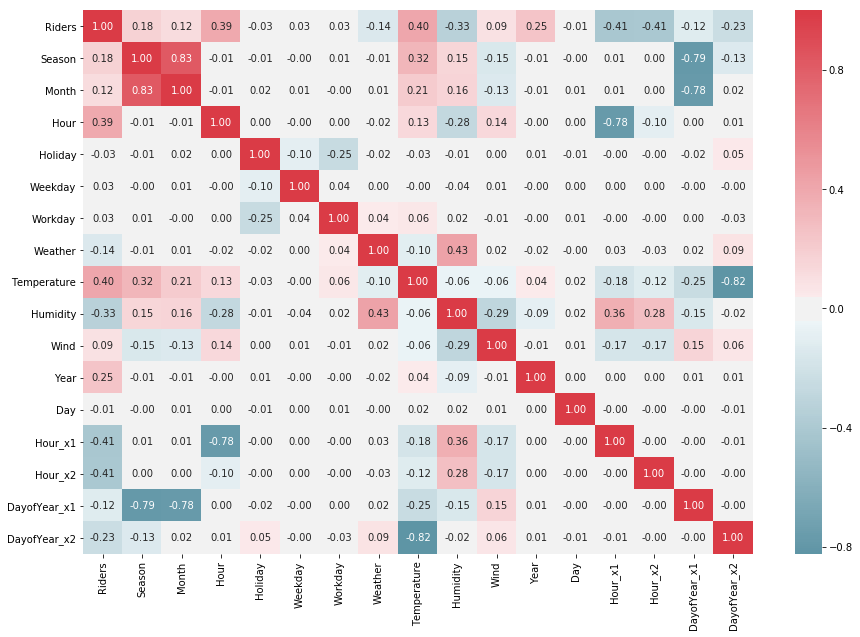

In [31]:
plt.figure(figsize=(15, 10))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df.drop('date', axis=1).corr(), cmap=colormap, center=0, annot=True, fmt=".2f")
plt.show()

# Modeling

In [32]:
df.columns

Index(['Riders', 'Season', 'Month', 'Hour', 'Holiday', 'Weekday', 'Workday',
       'Weather', 'Temperature', 'Humidity', 'Wind', 'Year', 'date', 'Day',
       'Hour_x1', 'Hour_x2', 'DayofYear_x1', 'DayofYear_x2'],
      dtype='object')

In [33]:
X1_cols = ['Season', 'Hour', 'Workday', 'Weather', 'Temperature', 'Humidity', 'Wind']
X2_cols = ['Workday', 'Weather', 'Temperature', 'Humidity', 'Wind', 
           'Hour_x1', 'Hour_x2', 'DayofYear_x1', 'DayofYear_x2']

In [34]:
X = df[X2_cols]

# One-hot Encoding

In [35]:
X['Mist'] = (X.Weather == 2)
X['Rain'] = (X.Weather == 3)
X.drop('Weather', axis=1, inplace=True)

# Normalization

In [36]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit_transform(X)

array([[-1.        , -0.42857143,  0.58695652, ...,  0.99985184,
        -1.        , -1.        ],
       [-1.        , -0.44537815,  0.56521739, ...,  0.99985184,
        -1.        , -1.        ],
       [-1.        , -0.44537815,  0.56521739, ...,  0.99985184,
        -1.        , -1.        ],
       ...,
       [ 1.        , -0.4789916 ,  0.13043478, ...,  0.99985184,
        -1.        , -1.        ],
       [ 1.        , -0.44537815,  0.04347826, ...,  0.99985184,
        -1.        , -1.        ],
       [ 1.        , -0.44537815,  0.23913043, ...,  0.99985184,
        -1.        , -1.        ]])

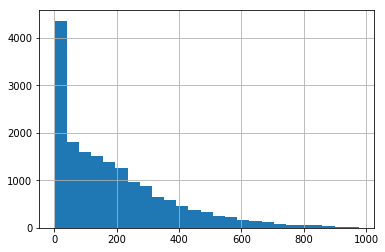

In [37]:
y = df.Riders
y.hist(bins=25);

# Log Transform Target Veriable

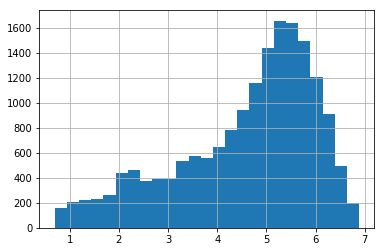

In [38]:
y = np.log1p(y)
y.hist(bins=25);

# Split train and test sets

In [39]:
# X_train = X[df.Year == 2011]
# y_train = y[df.Year == 2011]
# X_test = X[df.Year == 2012]
# y_test = y[df.Year == 2012]

TBC...

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [41]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [42]:
from sklearn import metrics
y_pred = reg.predict(X_test)
metrics.explained_variance_score(y_test, y_pred)

0.5775274429706294

In [43]:
y_pred

array([3.19574456, 3.63743355, 5.37965592, ..., 6.05248668, 3.61325739,
       4.30628125])

In [44]:
metrics.r2_score(y_test, y_pred)

0.5774774306300348

In [45]:
metrics.mean_squared_error(y_test, y_pred)

0.8385926790235491

In [46]:
metrics.mean_squared_error(y_train, reg.predict(X_train))

0.8154302468395913

In [47]:
metrics.r2_score(y_train, reg.predict(X_train))

0.595896831590377

# Classification

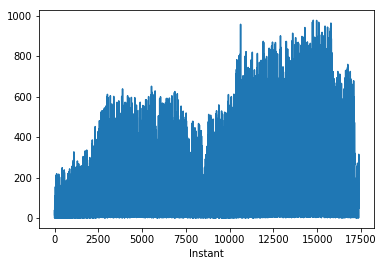

In [48]:
df.Riders.plot()

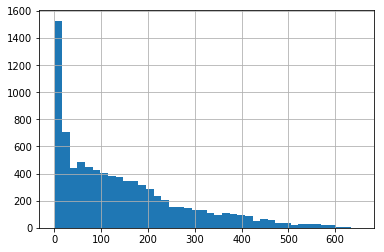

In [49]:
df.Riders[df.Year == 2011].hist(bins=40)

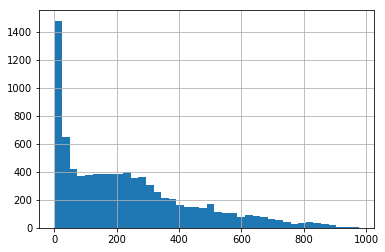

In [50]:
df.Riders[df.Year == 2012].hist(bins=40)

In [51]:
df.Riders[df.Year == 2011].quantile(0.8)

243.0

In [52]:
df.Riders[df.Year == 2012].quantile(0.8)

400.40000000000055

In [53]:
y = ((df.Year == 2011) & (df.Riders > 243)) | ((df.Year == 2012) & (df.Riders > 400))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [63]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def classification_evaluation(clf):
    print(clf.__class__.__name__)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print('Accuracy: {}'.format(accuracy))
    
    # Precision-Recall curve
    probs = clf.predict_proba(X_test)
    precision, recall, thresholds = metrics.precision_recall_curve(y_test, probs[:, 1])
    average_precision = metrics.average_precision_score(y_test, probs[:, 1])
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()
    
    # Receiver Operating Characteristic (ROC) curve
    fpr, tpr, thresholds = metrics.roc_curve(y_test, probs[:, 1])
    auc = metrics.auc(fpr, tpr)
    plt.step(fpr, tpr, color='b', alpha=0.2,
             where='post')
    plt.fill_between(fpr, tpr, step='post', alpha=0.2,
                     color='b')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) curve: AUC={0:0.2f}'.format(auc))
    plt.show()
    
    # Confusion Matrix
    class_names = ['idle', 'busy']
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')
    plt.show()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')
    plt.show()
    
    return accuracy

LogisticRegression
Accuracy: 0.825652841781874


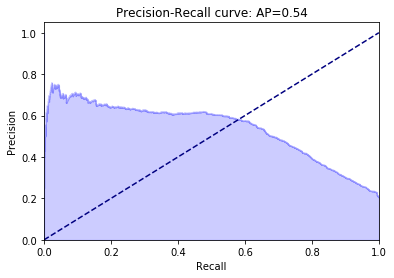

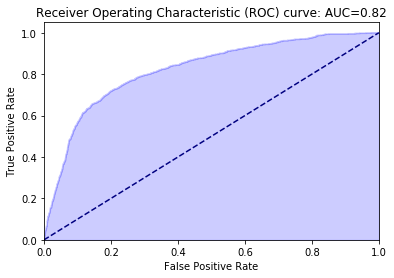

Confusion matrix, without normalization
[[3930  230]
 [ 678  370]]


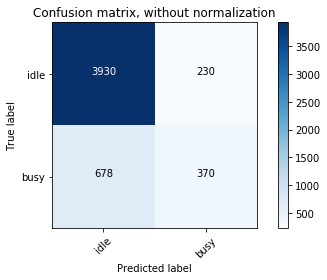

Normalized confusion matrix
[[0.94 0.06]
 [0.65 0.35]]


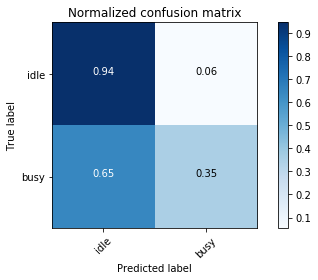

LinearDiscriminantAnalysis
Accuracy: 0.8266129032258065


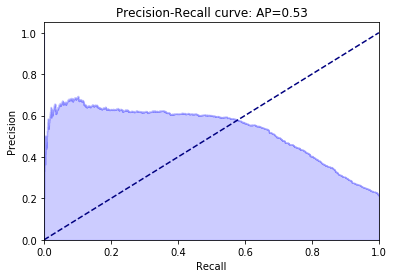

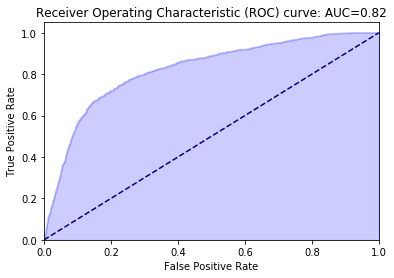

Confusion matrix, without normalization
[[3927  233]
 [ 670  378]]


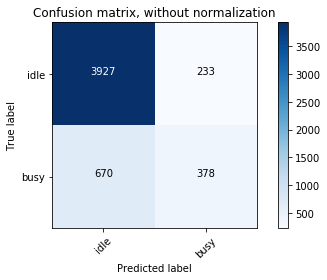

Normalized confusion matrix
[[0.94 0.06]
 [0.64 0.36]]


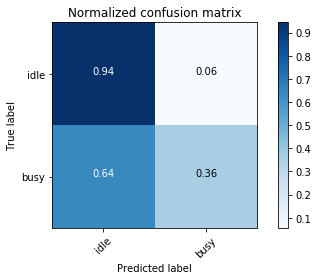

QuadraticDiscriminantAnalysis
Accuracy: 0.8982334869431644


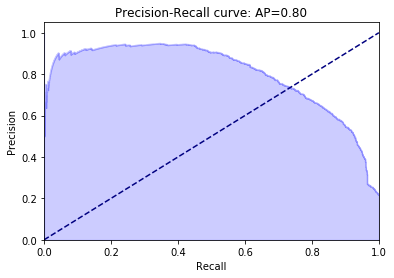

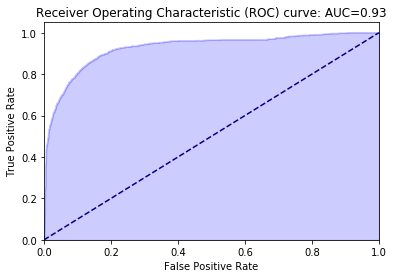

Confusion matrix, without normalization
[[3984  176]
 [ 354  694]]


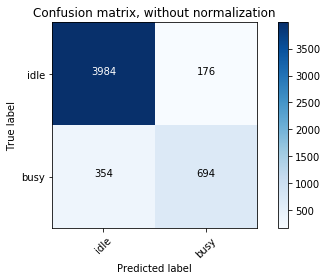

Normalized confusion matrix
[[0.96 0.04]
 [0.34 0.66]]


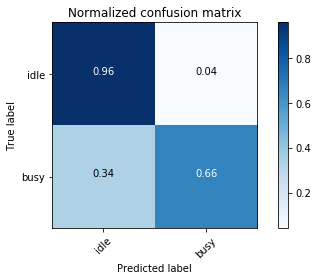

KNeighborsClassifier
Accuracy: 0.9051459293394777


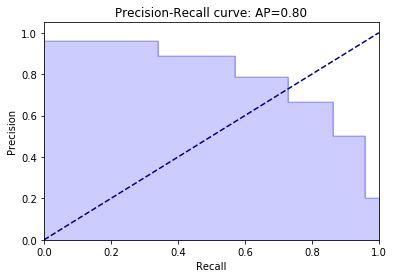

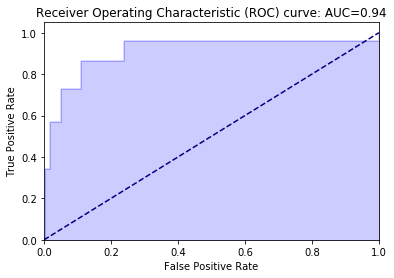

Confusion matrix, without normalization
[[3951  209]
 [ 285  763]]


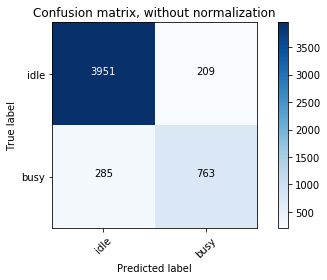

Normalized confusion matrix
[[0.95 0.05]
 [0.27 0.73]]


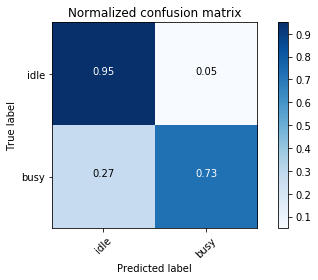

GaussianNB
Accuracy: 0.8266129032258065


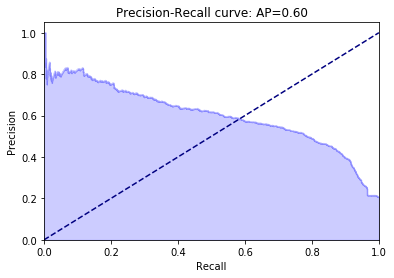

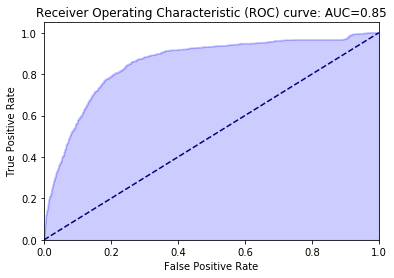

Confusion matrix, without normalization
[[3621  539]
 [ 364  684]]


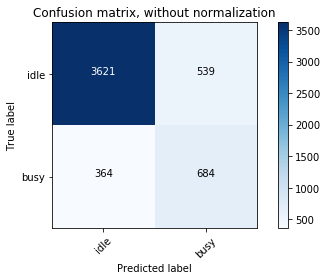

Normalized confusion matrix
[[0.87 0.13]
 [0.35 0.65]]


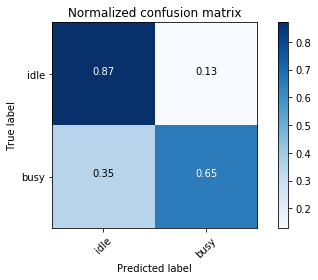

RandomForestClassifier
Accuracy: 0.9527649769585254


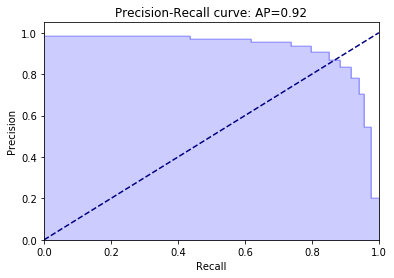

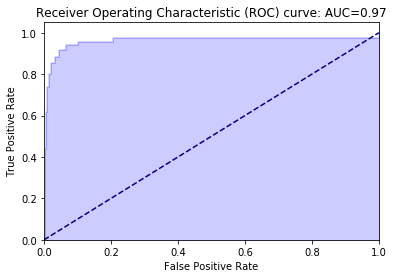

Confusion matrix, without normalization
[[4069   91]
 [ 155  893]]


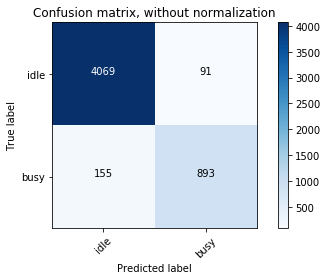

Normalized confusion matrix
[[0.98 0.02]
 [0.15 0.85]]


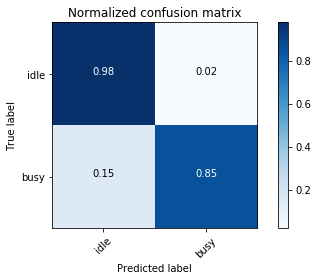

AdaBoostClassifier
Accuracy: 0.8807603686635944


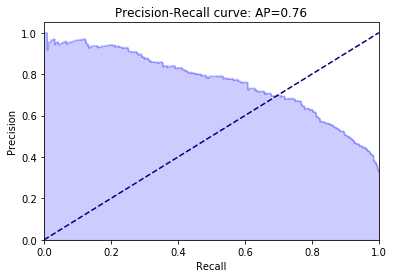

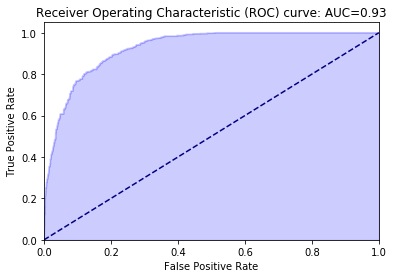

Confusion matrix, without normalization
[[3981  179]
 [ 442  606]]


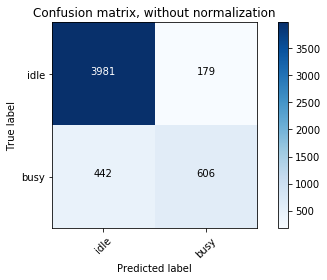

Normalized confusion matrix
[[0.96 0.04]
 [0.42 0.58]]


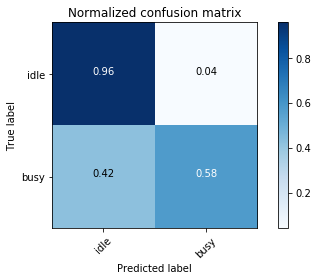

In [64]:
clf_list = [LogisticRegression(),
            LinearDiscriminantAnalysis(),
            QuadraticDiscriminantAnalysis(),
            KNeighborsClassifier(),
            GaussianNB(),
            RandomForestClassifier(),
            AdaBoostClassifier()]

clf_accuracies = pd.Series()
for clf in clf_list:
    accuracy = classification_evaluation(clf)
    clf_accuracies[clf.__class__.__name__] = accuracy

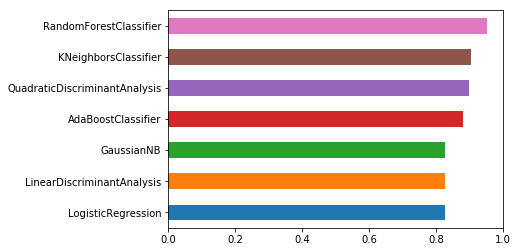

In [71]:
clf_accuracies.sort_values().plot.barh();